In [1215]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate, utils, spikegen
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
from statistics import mean
import matplotlib.pyplot as plt

In [1216]:
num_steps = 25 # number of time steps
batch_size = 1
beta = 0.8  # neuron decay rate
spike_grad = surrogate.fast_sigmoid() # surrogate gradient

Данные об отдельных объектах представляют собой точки в пространстве. По их динамике нам нужно делать вывод, собираются ли они в нас врезаться. Сначала смоделируем движение одной точки в пространстве. Для этого нужен простенький генератор: считаем, что мы в центре цилиндрической системы координат, рандомим начальное положение точки, после этого с шансом 50/50 решаем, точка будет врезаться в нас или нет. Если нет, то рандомим конечное положение и добавляем промежуточных точек. Если да, то то же, но конечное положение - центр координат. 

In [1217]:
import random
import numpy as np
camera_pos = {'r' : 0, 'phi' : 0, 'h' : 0}
field_depth_m = 20
field_height_m = 20
fov_deg = 120

In [1218]:
class single_data:
  full_circle = 360

  def __init__(self, field_depth_m, field_height_m, fov_deg, camera_pos: dict, output_length = 50, camera_size_r = 0.5, camera_size_h = 0.5, time_steps = 5):
    if(random.randint(0, 1)):
      self.crashes_flag = True

      start_pos = {'r' : random.random() * field_depth_m, 'phi' : random.random() * fov_deg, 'h' : random.random() * field_height_m}
      end_pos = {'r' : camera_pos['r'] + (random.random() * camera_size_r), 
                 'phi' : random.random() * self.full_circle, 
                 'h' : camera_pos['h'] + (random.random() * camera_size_h)}
    else: 
      self.crashes_flag = False
      start_pos = {'r' : random.random() * field_depth_m, 'phi' : random.random() * fov_deg, 'h' : random.random() * field_height_m}
      end_pos = {'r' : random.random() * field_depth_m, 'phi' : random.random() * fov_deg, 'h' : random.random() * field_height_m}
      if abs(end_pos['r'] - camera_pos['r']) <= camera_size_r and abs(end_pos['h'] - camera_pos['h']) <= camera_size_h : self.crashes_flag = True

    flat_sequence = np.array([np.linspace(start=start_pos['r'],    stop=end_pos['r'],      num=output_length), 
                                       np.linspace(start=start_pos['phi'],    stop=end_pos['phi'],  num=output_length),
                                       np.linspace(start=start_pos['h'],      stop=end_pos['h'],    num=output_length)])
    flat_sequence = normalize(flat_sequence)
    flat_sequence = flat_sequence.transpose()

    # flat_sequence = torch.tensor(np.array([spikegen.latency(torch.tensor(row), num_steps=time_steps, linear=True) for row in flat_sequence]))

    self.position_sequence = torch.tensor(flat_sequence, dtype=torch.float32).unsqueeze(1)

  
print(single_data(field_depth_m, field_height_m, fov_deg, camera_pos, output_length=4).position_sequence.shape)

torch.Size([4, 1, 3])


In [1219]:
def create_training_set(num_elements : int, output_length : int, field_depth_m, field_height_m, fov_deg, camera_pos: dict):
  return [single_data(field_depth_m, field_height_m, fov_deg, camera_pos, output_length) for _ in range(num_elements)]

In [ ]:
class SnnNet(nn.Module):
    def __init__(self):
        super(SnnNet, self).__init__()

        self.Lin1 = nn.Linear(3, 3)
        self.Leaky1 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)

        self.Lin2 = nn.Linear(3, 3)
        self.Leaky2 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)

        self.Lin3 = nn.Linear(3, 3)
        self.Leaky3 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)

        self.Lin4 = nn.Linear(3, 1)
        self.Leaky4 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad, output=True)

        self.spikeLayers = [self.Lin1, self.Leaky1, self.Lin2, self.Leaky2, self.Lin3, self.Leaky3]
    

    def forward(self, x) -> list:
        mem1 = self.Leaky1.reset_mem()
        mem2 = self.Leaky2.reset_mem()
        mem3 = self.Leaky3.reset_mem()
        mem4 = self.Leaky4.reset_mem()

        self.spike_mem = []
        self.mem1_mem = []

        # print(x.shape)
        for state in range(x.shape[0]):
            out = self.Lin1(x[state])
            out, mem1 = self.Leaky1(out, mem1)
            # out, mem1 = self.Leaky1(x[state], mem1)
            self.mem1_mem += mem1

            out = self.Lin2(out)
            out, mem2 = self.Leaky2(out, mem2)

            # out = self.Lin3(out)
            # out, mem3 = self.Leaky3(out, mem3)

            out = self.Lin4(out)
            out, mem4 = self.Leaky4(out, mem4)

            self.spike_mem += out
        self.mem1_mem = torch.stack(self.mem1_mem)
        self.spike_mem = torch.stack(self.spike_mem)
        return self.spike_mem

In [1221]:
net = SnnNet()

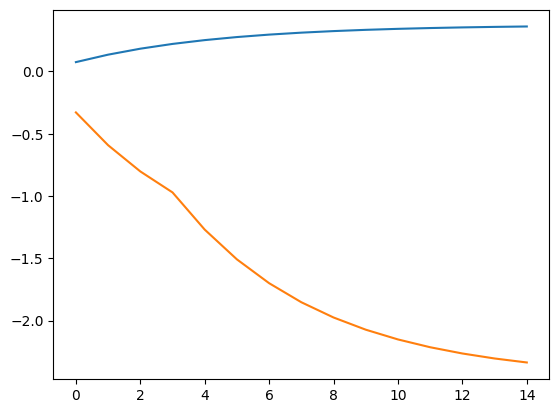

In [1222]:
fig, ax = plt.subplots()

tens = torch.ones(15, 1, 3)
net(tens)
ax.plot(net.mem1_mem.detach().numpy()[:, 0])

tens = torch.zeros(15, 1, 3)
for i in range(4):
    tens[i][0][0] = 0.5
# print(tens)
net(tens)
ax.plot(net.mem1_mem.detach().numpy()[:, 0])

In [1223]:
from IPython.display import clear_output
%matplotlib inline 
#pip install jupyter ipympl - for this

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

# arr = []
# for i in range (100):
#   arr.append(i**2)
#   live_plot(arr)


In [1224]:
train_net = create_training_set(500, num_steps, field_depth_m, field_height_m, fov_deg, camera_pos)
spike_recording = [] # record spikes over time
loss_stats = []


num_epoch = 50
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

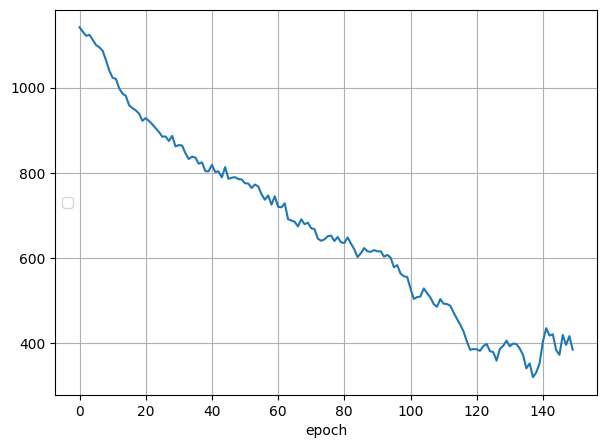

In [1229]:
net.train()
for epoch in range(num_epoch):
    random.shuffle(train_net)
    train_iter = iter(train_net)
    ep_loss = 0
    for i, data in enumerate(train_iter):
        target = torch.tensor([1 if data.crashes_flag else 0], dtype=torch.float32)
        loss = torch.zeros(1, dtype=torch.float32, device='cpu')

        spike = net(data.position_sequence)
        # print(len(spike))
        for step in spike[2:]: # loop over time
            # spike_recording.append(spike.item()) # record spikes in list
            loss += criterion(step, target)
            # loss_val += loss.item()
        # print(target.item(), torch.tensor(spike).mean().item(), loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_loss += loss.item()
    print(ep_loss / i)
    loss_stats += [ep_loss / i]
    live_plot(loss_stats)


In [1231]:
def calc_err(spikes : list, target : int):
  cntr = 0
  for spike in spikes: 
    if spike.item() == target: cntr += 1
  return cntr / len(spikes)

net.eval()
random.shuffle(train_net)
avg_err = 0
for i, data in enumerate(iter(train_net)):
  target = torch.tensor([1 if data.crashes_flag else 0], dtype=torch.float32)
  loss = torch.zeros(1, dtype=torch.float32, device='cpu')
  spike = net(data.position_sequence)
  for step in spike[2:]: # loop over time
    # spike_recording.append(spike.item()) # record spikes in list
    loss += criterion(step, target)
    # loss_val += loss.item()
  avg_err += calc_err(spike[2:], target.item())
  print(calc_err(spike[2:], target.item()), spike.mean().item(), target.item())
print(avg_err / i)

1.0 0.0 0.0
1.0 0.9599999785423279 1.0
1.0 0.0 0.0
1.0 0.9599999785423279 1.0
0.8260869565217391 0.1599999964237213 0.0
0.8260869565217391 0.1599999964237213 0.0
0.13043478260869565 0.8399999737739563 0.0
0.9565217391304348 0.9200000166893005 1.0
0.30434782608695654 0.6399999856948853 0.0
1.0 0.0 0.0
0.34782608695652173 0.6000000238418579 0.0
1.0 0.9599999785423279 1.0
1.0 0.9599999785423279 1.0
1.0 0.0 0.0
0.8695652173913043 0.11999999731779099 0.0
1.0 0.9599999785423279 1.0
0.9565217391304348 0.9200000166893005 1.0
0.782608695652174 0.7599999904632568 1.0
1.0 0.9599999785423279 1.0
1.0 0.9599999785423279 1.0
0.9565217391304348 0.9200000166893005 1.0
1.0 0.0 0.0
1.0 0.9599999785423279 1.0
0.9130434782608695 0.8799999952316284 1.0
1.0 0.9599999785423279 1.0
0.9130434782608695 0.8799999952316284 1.0
1.0 1.0 1.0
1.0 0.9599999785423279 1.0
0.5652173913043478 0.4000000059604645 0.0
0.5217391304347826 0.4399999976158142 0.0
1.0 0.9599999785423279 1.0
0.8260869565217391 0.1599999964237213 0.

Теперь тестируем точность с алгоритмической доработкой: проверяется плотность спайков на выходе и если она превышает 0.5, то будем считать, что авария предсказана вовремя.

In [1232]:
def predict_crash(spikes : torch.Tensor):
  return 1 if spikes.mean().item() > 0.5 else 0

In [1237]:
random.shuffle(train_net)
avg_acc = 0
for i, data in enumerate(iter(train_net)):
  target = 1 if data.crashes_flag else 0
  spike = net(data.position_sequence)
  avg_acc += 1 if predict_crash(spike[2:]) == target else 0
  print(avg_acc / (i + 1), predict_crash(spike[2:]), target)
print(avg_acc / (i + 1))

0.0 1 0
0.5 1 1
0.6666666666666666 1 1
0.5 0 1
0.6 1 1
0.6666666666666666 0 0
0.7142857142857143 0 0
0.75 0 0
0.6666666666666666 1 0
0.6 1 0
0.6363636363636364 1 1
0.5833333333333334 1 0
0.6153846153846154 0 0
0.5714285714285714 1 0
0.6 0 0
0.625 0 0
0.6470588235294118 0 0
0.6111111111111112 1 0
0.5789473684210527 1 0
0.6 0 0
0.6190476190476191 1 1
0.6363636363636364 1 1
0.6521739130434783 1 1
0.6666666666666666 1 1
0.68 0 0
0.6923076923076923 1 1
0.7037037037037037 0 0
0.6785714285714286 1 0
0.6896551724137931 0 0
0.6666666666666666 1 0
0.6774193548387096 1 1
0.6875 1 1
0.696969696969697 1 1
0.7058823529411765 0 0
0.7142857142857143 1 1
0.7222222222222222 1 1
0.7297297297297297 1 1
0.7368421052631579 0 0
0.7435897435897436 0 0
0.75 0 0
0.7560975609756098 0 0
0.7619047619047619 0 0
0.7674418604651163 0 0
0.7727272727272727 1 1
0.7777777777777778 0 0
0.782608695652174 0 0
0.7872340425531915 0 0
0.7916666666666666 0 0
0.7959183673469388 0 0
0.8 1 1
0.803921568627451 0 0
0.807692307692307